In [1]:
# !python --version

In [2]:
import subprocess
whls = [
    "/kaggle/input/pyg-cp37-pt111/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl",
    "/kaggle/input/pyg-cp37-pt111/torch_geometric-2.2.0-py3-none-any.whl",
    "/kaggle/input/pyg-cp37-pt111/ruamel.yaml-0.17.21-py3-none-any.whl",
]
for w in whls:
    print("Installing", w)
    subprocess.call(["pip", "install", w, "--no-deps", "--upgrade"])

Installing /kaggle/input/pyg-cp37-pt111/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/pyg-cp37-pt111/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl


Installing /kaggle/input/pyg-cp37-pt111/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/pyg-cp37-pt111/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl
Installing /kaggle/input/pyg-cp37-pt111/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl


Processing /kaggle/input/pyg-cp37-pt111/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl
Installing /kaggle/input/pyg-cp37-pt111/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl


Processing /kaggle/input/pyg-cp37-pt111/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl
Installing /kaggle/input/pyg-cp37-pt111/torch_geometric-2.2.0-py3-none-any.whl


Processing /kaggle/input/pyg-cp37-pt111/torch_geometric-2.2.0-py3-none-any.whl
Installing /kaggle/input/pyg-cp37-pt111/ruamel.yaml-0.17.21-py3-none-any.whl


Processing /kaggle/input/pyg-cp37-pt111/ruamel.yaml-0.17.21-py3-none-any.whl


In [3]:
import torch
import torch.utils.data as data_utils
import torch_geometric
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv

import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import tqdm
from IPython import display
from types import MethodType
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import networkx as nx
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.cuda.amp import autocast
from tabulate import tabulate
from skimage.segmentation import slic
from skimage.segmentation import slic, mark_boundaries


In [4]:
transforms = torchvision.transforms
data_transform = {
    "train": transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                    transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]),
    "tes": transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])}        


In [5]:
train_dataset = torchvision.datasets.ImageFolder("/kaggle/input/brain-tumor-classification-mri/Training", transform=data_transform["train"])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torchvision.datasets.ImageFolder("/kaggle/input/brain-tumor-classification-mri/Testing", transform=data_transform["tes"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

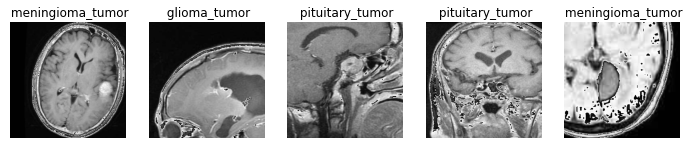

In [6]:
def display_dataset_samples(dataset, num_samples=4):
    # Display some random samples from the dataset
    indices = torch.randint(0, len(dataset), (num_samples,))
    sample_loader = DataLoader(dataset, batch_size=num_samples, sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))

    for images, labels in sample_loader:
        plt.figure(figsize=(12, 5))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(transforms.ToPILImage()(images[i]))
            plt.title(f' {dataset.classes[labels[i].item()]}')  # Use dataset.classes to get the label name
            plt.axis('off')
        plt.show()
        break

display_dataset_samples(train_dataset, num_samples=5)


Classes:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


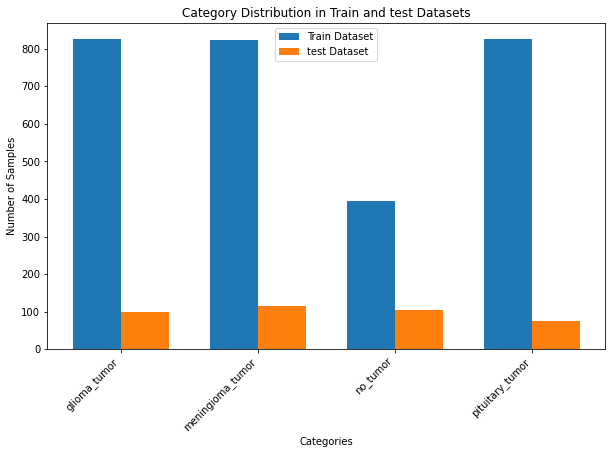

Number of Training Data points:  2870
Number of Testing Data points:  394


In [7]:
def plot_category_distribution(train_dataset, test_dataset):
    # Get the class names/categories from the dataset
    classes = train_dataset.classes
    print("Classes: ", classes)

    # Count occurrences of each category in the training dataset
    train_counts = [0] * len(classes)
    for _, label in train_dataset:
        train_counts[label] += 1

    # Count occurrences of each category in the test dataset
    test_counts = [0] * len(classes)
    for _, label in test_dataset:
        test_counts[label] += 1

    # Plot the bar graph
    width = 0.35  
    x = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train Dataset')
    rects2 = ax.bar(x + width/2, test_counts, width, label='test Dataset')

    # x-axis labels.
    ax.set_xlabel('Categories')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Category Distribution in Train and test Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.legend()

    plt.show()



plot_category_distribution(train_dataset, test_dataset)
print("Number of Training Data points: ",len(train_dataset))
print("Number of Testing Data points: ",len(test_dataset))


In [8]:
dtype = torch.float16
device = torch.device("cuda:0")
def train(model: nn.Module, num_epochs, train_loader, test_loader, lr):
    model.type(dtype)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    lrc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr/10)
    loss_array = []
    acc_array = []
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        running_loss, c = 0, 0
        
        for inputs, target in train_loader:
            inputs = inputs.type(dtype)
            inputs = inputs.to(device)
            target = target.to(device)

            y_pred = model(inputs)
            l = loss(y_pred, target)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            running_loss += l
            c += 1
        
        loss_array.append(running_loss.item() / c)
        acc_array.append(test(model, test_loader))
        
    return loss_array, acc_array

In [9]:
@torch.no_grad()
def test(model,test_loader):
    correct=0
    total=0
    model.eval()
    model.to(device)
    model.type(dtype)
    
    with torch.no_grad():
        for data in test_loader:
            image,lables=data
            outputs=model(image.type(dtype).to(device))
            _,predicted=torch.max(outputs.data,dim=1)
            total+=lables.size(0)
            correct+=(predicted==lables.to(device)).sum().item()
    acc = correct/total
    return acc



In [10]:
# def train_tumor(model, epochs, batch_size = 32,lr=0.001):
# #     train_dataset = torchvision.datasets.ImageFolder("/kaggle/input/brain-tumor-classification-mri/Training",transform=data_transform["train"])
# #     train_loader = data_utils.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
# #     test_dataset = torchvision.datasets.ImageFolder("/kaggle/input/brain-tumor-classification-mri/Testing",transform=data_transform["tes"])
# #     test_loader = data_utils.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
#     train(model, epochs, train_loader,test_loader,lr)
#     test(model,test_loader)

* VGG-16 100, lr == 0.001

In [11]:
class GraphCNN_VGG16(nn.Module):
    def __init__(self,k, num_classes):
        super().__init__()
        self.k = k
        self.num_classes = num_classes
        self.vgg16 = models.vgg16(pretrained=True)  # Load pre-trained VGG-16
        self.conv1 = torch_geometric.nn.GATConv(512, 256)  # Adjust input dimension here
        self.dropout = nn.Dropout(0.5)
        self.conv2 = torch_geometric.nn.GATConv(256, num_classes)
        
    def forward_features(self,X):
        features = self.vgg16.features(X)  # Extract features using VGG-16
#         print("VGG16 Features Shape:", features.shape)
#         print("Features: ", features)
        return features

    def convert_graph(self, x):
        b,c,h,w = x.shape
        device = x.device
        k = self.k
        x = torch.permute(x,(0,2,3,1)).reshape((b,h*w,c))
        y = torch.cdist(x,x,2)  # [b, hw, hw]
        _,idx = torch.topk(y,k,-1)
        source = torch.arange(h*w,device=device).repeat_interleave(k).repeat(b)
        target = torch.flatten(idx)
        step = torch.arange(b,device=device).repeat_interleave(h*w*k)*h*w
        adj = torch.row_stack([source,target]) + step
        return x.reshape((b*h*w,c)), adj.long()

    def froward_gcn(self,X,adj):
        X = self.conv1(X,adj)
        X = self.dropout(X)
        X = self.conv2(X,adj)  # (B*7*7, num_classes)
        return X

    def forward(self,X):
        batch = X.shape[0]
        X = self.forward_features(X)
        X,adj = self.convert_graph(X)
        X = self.froward_gcn(X,adj)
        X = torch.reshape(X,(batch, -1, self.num_classes))
        X = torch.mean(X,1) # (B, num_classes)
        return X

* Densenet -121 100 Lr = 0.0001

In [12]:
class GraphCNN_Densenet121(nn.Module):
    def __init__(self,k, num_classes):
        super().__init__()
        self.k = k
        self.num_classes = num_classes
        self.densenet = models.densenet121(pretrained=True)  # Load pre-trained DenseNet-121
        self.conv1 = torch_geometric.nn.GATConv(1024, 256)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = torch_geometric.nn.GATConv(256, num_classes)
        
    def forward_features(self,X):
        features = self.densenet.features(X)  # Extract features using DenseNet-121
#         print("DenseNet121 Features Shape:", features.shape)
#         print("Features: ", features)
        return features

    def convert_graph(self, x):
        b,c,h,w = x.shape
        device = x.device
        k = self.k
        x = torch.permute(x,(0,2,3,1)).reshape((b,h*w,c))
        y = torch.cdist(x,x,2)  # [b, hw, hw]
        _,idx = torch.topk(y,k,-1)
        source = torch.arange(h*w,device=device).repeat_interleave(k).repeat(b)
        target = torch.flatten(idx)
        step = torch.arange(b,device=device).repeat_interleave(h*w*k)*h*w
        adj = torch.row_stack([source,target]) + step
        return x.reshape((b*h*w,c)), adj.long()

    def froward_gcn(self,X,adj):
        X = self.conv1(X,adj)
        X = self.dropout(X)
        X = self.conv2(X,adj)  # (B*7*7, num_classes)
        return X

    def forward(self,X):
        batch = X.shape[0]
        X = self.forward_features(X)
        X,adj = self.convert_graph(X)
        X = self.froward_gcn(X,adj)
        X = torch.reshape(X,(batch, -1, self.num_classes))
        X = torch.mean(X,1) # (B, num_classes)
        return X


* Resnet-18 30 lr = 0.001

In [13]:
class GraphCNN_Resnet18(nn.Module):
    def __init__(self,k, num_classes):
        super().__init__()
        self.k = k
        self.num_classes = num_classes
        self.resnet = torchvision.models.resnet18(True)
        self.resnet._forward_impl = MethodType(_forward_impl,self.resnet)
        self.conv1 = torch_geometric.nn.GATConv(512,256)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = torch_geometric.nn.GATConv(256,num_classes)
    def forward_features(self,X):
        # B * 512 * 7 * 7
        features = self.resnet(X)
#         print("ResNet-18 Features Shape:", features.shape)
#         print("Features: ", features)
        return features

    def convert_graph(self, x):
        b,c,h,w = x.shape
        device = x.device
        k = self.k
        x = torch.permute(x,(0,2,3,1)).reshape((b,h*w,c))
        y = torch.cdist(x,x,2)  # [b, hw, hw]
        _,idx = torch.topk(y,k,-1)
        source = torch.arange(h*w,device=device).repeat_interleave(k).repeat(b)
        target = torch.flatten(idx)
        step = torch.arange(b,device=device).repeat_interleave(h*w*k)*h*w
        adj = torch.row_stack([source,target]) + step
        return x.reshape((b*h*w,c)), adj.long()

    def froward_gcn(self,X,adj):
        X = self.conv1(X,adj)
        X = self.dropout(X)
        X = self.conv2(X,adj)
        # (B*7*7, num_classes)
        return X

    def forward(self,X):
        batch = X.shape[0]
        X = self.forward_features(X)
        X,adj = self.convert_graph(X)
        X = self.froward_gcn(X,adj)
        X = torch.reshape(X,(batch, -1, self.num_classes))
        X = torch.mean(X,1)
        return X


In [14]:
def display_model_performance(loss_array, acc_array):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_array)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(acc_array)
    plt.title('test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


In [15]:
def display_loss_accuracy(loss_array, acc_array):
    for epoch, (loss, acc) in enumerate(zip(loss_array, acc_array), 1):
        print(f"Epoch {epoch} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")

In [16]:
def plot_roc_curve(model_name, model, test_loader, num_classes):
    print(f"Model Name: {model_name}")
    model.eval()
    device = next(model.parameters()).device
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert inputs to HalfTensor
            inputs = inputs.type(torch.cuda.HalfTensor)

            y_true.extend(labels.cpu().numpy())
            outputs = model(inputs)
            y_scores.extend(outputs.cpu().numpy())

    y_true = label_binarize(y_true, classes=np.arange(num_classes))
    y_scores = np.array(y_scores)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {} Model'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()


In [17]:
@torch.no_grad()
def test_with_predictions(model, test_loader):
    model.eval()
    model.to(device)
    model.type(dtype)

    all_labels = []
    all_predictions = []

    for data in test_loader:
        images, labels = data
        images = images.type(dtype).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.cpu().numpy())

    return all_labels, all_predictions

In [46]:
model_Resnet18 = GraphCNN_Resnet18(k=8,num_classes=4)


loss_array_Resnet18, acc_array_Resnet18 = train(model_Resnet18, 100, train_loader, test_loader, lr=0.001)

            
display_loss_accuracy(loss_array_Resnet18, acc_array_Resnet18)

100%|██████████| 100/100 [41:35<00:00, 24.96s/it]

Epoch 1 - Loss: 1.2549 - Accuracy: 0.4365
Epoch 2 - Loss: 0.8840 - Accuracy: 0.3934
Epoch 3 - Loss: 0.6378 - Accuracy: 0.5203
Epoch 4 - Loss: 0.5476 - Accuracy: 0.5305
Epoch 5 - Loss: 0.4788 - Accuracy: 0.5457
Epoch 6 - Loss: 0.4441 - Accuracy: 0.5558
Epoch 7 - Loss: 0.4274 - Accuracy: 0.5736
Epoch 8 - Loss: 0.3868 - Accuracy: 0.6168
Epoch 9 - Loss: 0.3688 - Accuracy: 0.6269
Epoch 10 - Loss: 0.3601 - Accuracy: 0.6345
Epoch 11 - Loss: 0.3410 - Accuracy: 0.6396
Epoch 12 - Loss: 0.3349 - Accuracy: 0.6802
Epoch 13 - Loss: 0.3153 - Accuracy: 0.6853
Epoch 14 - Loss: 0.2776 - Accuracy: 0.6421
Epoch 15 - Loss: 0.2717 - Accuracy: 0.6345
Epoch 16 - Loss: 0.2722 - Accuracy: 0.6802
Epoch 17 - Loss: 0.2743 - Accuracy: 0.6523
Epoch 18 - Loss: 0.2597 - Accuracy: 0.7107
Epoch 19 - Loss: 0.2437 - Accuracy: 0.6878
Epoch 20 - Loss: 0.2533 - Accuracy: 0.6701
Epoch 21 - Loss: 0.2642 - Accuracy: 0.7132
Epoch 22 - Loss: 0.2432 - Accuracy: 0.7234
Epoch 23 - Loss: 0.2531 - Accuracy: 0.7310
Epoch 24 - Loss: 0.2

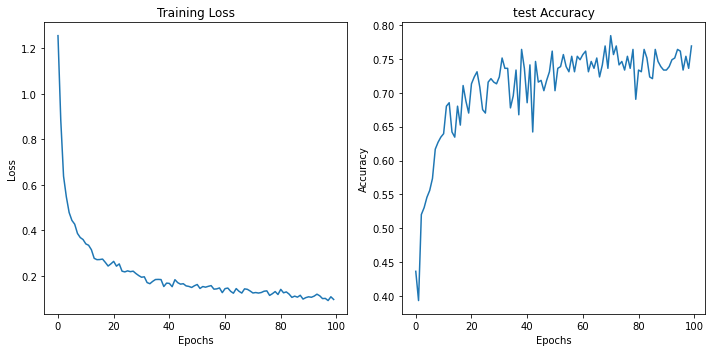

In [47]:
display_model_performance(loss_array_Resnet18, acc_array_Resnet18)

In [48]:
acc_Resnet18 = test(model_Resnet18, test_loader)

            
print("Test Accuracy: ", acc_Resnet18)

Test Accuracy:  0.7563451776649747


In [49]:
# Evaluate the model and get labels and predictions
true_labels, pred_labels = test_with_predictions(model_Resnet18, test_loader)

# Compute confusion matrix
conf_matrix_Resnet18 = confusion_matrix(true_labels, pred_labels)

# Compute classification report
class_report_Resnet18 = classification_report(true_labels, pred_labels)


In [50]:
print("Confusion Matrix:")
print(conf_matrix_Resnet18)

Confusion Matrix:
[[ 28  52  20   0]
 [  0 115   0   0]
 [  0   1 104   0]
 [  0  15   6  53]]


In [51]:
print("\nClassification Report:")
print(class_report_Resnet18)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.44       100
           1       0.63      1.00      0.77       115
           2       0.80      0.99      0.89       105
           3       1.00      0.72      0.83        74

    accuracy                           0.76       394
   macro avg       0.86      0.75      0.73       394
weighted avg       0.84      0.76      0.73       394



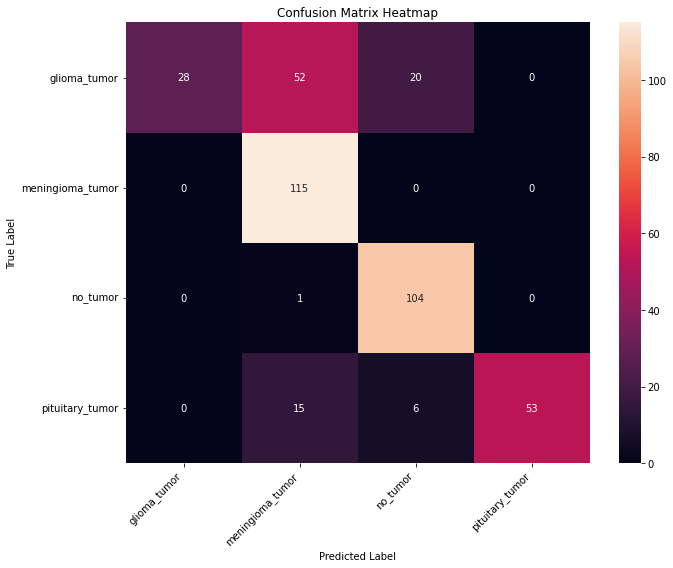

In [52]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix Heatmap - Resnet-18")
sns.heatmap(conf_matrix_Resnet18, annot=True, fmt="d", 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Model Name: GNN-ResNet18


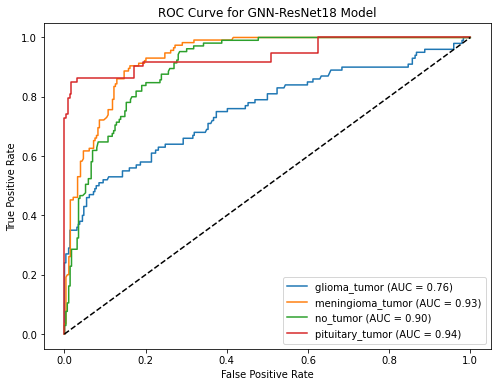

In [53]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
plot_roc_curve("GNN-ResNet18", model_Resnet18, test_loader, num_classes=4)

In [54]:
model_Densenet121 = GraphCNN_Densenet121(k=8,num_classes=4)


loss_array_Densenet121, acc_array_Densenet121 = train(model_Densenet121, 100, train_loader, test_loader, lr=0.0001)

            
display_loss_accuracy(loss_array_Densenet121, acc_array_Densenet121)

100%|██████████| 100/100 [53:47<00:00, 32.27s/it]

Epoch 1 - Loss: 2.1667 - Accuracy: 0.2437
Epoch 2 - Loss: 1.3958 - Accuracy: 0.3350
Epoch 3 - Loss: 1.0368 - Accuracy: 0.3934
Epoch 4 - Loss: 0.9264 - Accuracy: 0.4086
Epoch 5 - Loss: 0.8215 - Accuracy: 0.4188
Epoch 6 - Loss: 0.7722 - Accuracy: 0.4391
Epoch 7 - Loss: 0.7285 - Accuracy: 0.4695
Epoch 8 - Loss: 0.7063 - Accuracy: 0.4848
Epoch 9 - Loss: 0.6670 - Accuracy: 0.4264
Epoch 10 - Loss: 0.6368 - Accuracy: 0.4594
Epoch 11 - Loss: 0.5997 - Accuracy: 0.4924
Epoch 12 - Loss: 0.5872 - Accuracy: 0.5203
Epoch 13 - Loss: 0.5691 - Accuracy: 0.5025
Epoch 14 - Loss: 0.5778 - Accuracy: 0.4721
Epoch 15 - Loss: 0.5583 - Accuracy: 0.4898
Epoch 16 - Loss: 0.5372 - Accuracy: 0.5000
Epoch 17 - Loss: 0.5510 - Accuracy: 0.5228
Epoch 18 - Loss: 0.5226 - Accuracy: 0.5178
Epoch 19 - Loss: 0.5045 - Accuracy: 0.5406
Epoch 20 - Loss: 0.5115 - Accuracy: 0.5127
Epoch 21 - Loss: 0.5000 - Accuracy: 0.5102
Epoch 22 - Loss: 0.4740 - Accuracy: 0.5254
Epoch 23 - Loss: 0.4882 - Accuracy: 0.5102
Epoch 24 - Loss: 0.4

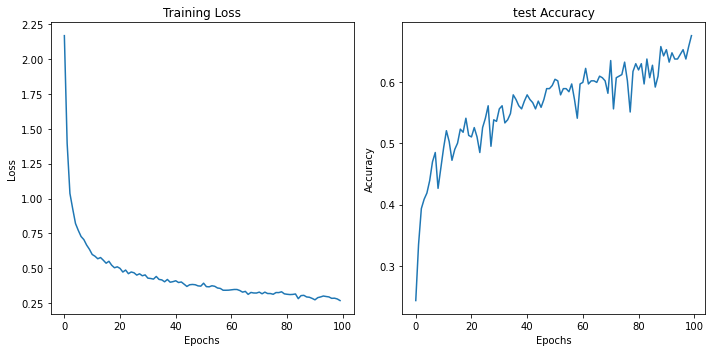

In [55]:
display_model_performance(loss_array_Densenet121, acc_array_Densenet121)

In [56]:
acc_Densenet121 = test(model_Densenet121, test_loader)

            
print("Test Accuracy: ", acc_Densenet121)

Test Accuracy:  0.6675126903553299


In [57]:
# Evaluate the model and get labels and predictions
true_labels, pred_labels = test_with_predictions(model_Resnet18, test_loader)

# Compute confusion matrix
conf_matrix_Densenet121 = confusion_matrix(true_labels, pred_labels)

# Compute classification report
class_report_Densenet121 = classification_report(true_labels, pred_labels)

In [58]:
print("Confusion Matrix:")
print(conf_matrix_Densenet121)

Confusion Matrix:
[[ 28  53  19   0]
 [  0 115   0   0]
 [  0   1 104   0]
 [  0  14   6  54]]


In [59]:
print("\nClassification Report:")
print(class_report_Densenet121)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.44       100
           1       0.63      1.00      0.77       115
           2       0.81      0.99      0.89       105
           3       1.00      0.73      0.84        74

    accuracy                           0.76       394
   macro avg       0.86      0.75      0.74       394
weighted avg       0.84      0.76      0.73       394



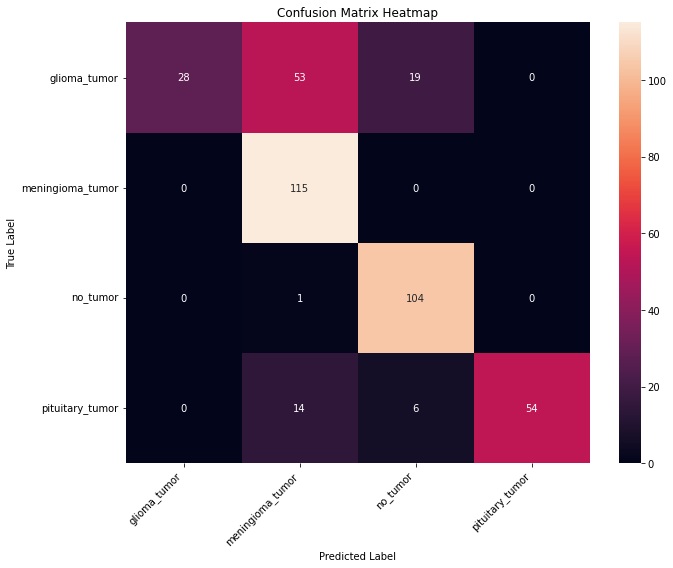

In [60]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix Heatmap - Densenet-121")
sns.heatmap(conf_matrix_Densenet121, annot=True, fmt="d", 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Model Name: GNN-Densenet121


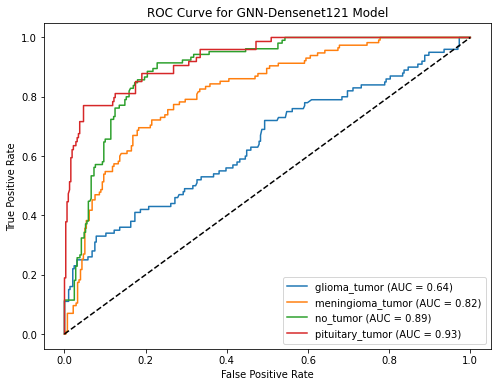

In [61]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
plot_roc_curve("GNN-Densenet121", model_Densenet121, test_loader, num_classes=4)

In [62]:
model_VGG16 = GraphCNN_VGG16(k=8,num_classes=4)


loss_array_VGG16, acc_array_VGG16 = train(model_VGG16, 100, train_loader, test_loader, lr=0.001)

            
display_loss_accuracy(loss_array_VGG16, acc_array_VGG16)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 100/100 [50:15<00:00, 30.16s/it]

Epoch 1 - Loss: 1.3257 - Accuracy: 0.2868
Epoch 2 - Loss: 1.0507 - Accuracy: 0.3706
Epoch 3 - Loss: 0.7944 - Accuracy: 0.4188
Epoch 4 - Loss: 0.6753 - Accuracy: 0.4695
Epoch 5 - Loss: 0.6049 - Accuracy: 0.5051
Epoch 6 - Loss: 0.5368 - Accuracy: 0.5381
Epoch 7 - Loss: 0.5222 - Accuracy: 0.5406
Epoch 8 - Loss: 0.4892 - Accuracy: 0.5508
Epoch 9 - Loss: 0.4597 - Accuracy: 0.5838
Epoch 10 - Loss: 0.4490 - Accuracy: 0.5457
Epoch 11 - Loss: 0.4174 - Accuracy: 0.6015
Epoch 12 - Loss: 0.4149 - Accuracy: 0.6091
Epoch 13 - Loss: 0.4142 - Accuracy: 0.5178
Epoch 14 - Loss: 0.3937 - Accuracy: 0.5685
Epoch 15 - Loss: 0.3837 - Accuracy: 0.6117
Epoch 16 - Loss: 0.3639 - Accuracy: 0.6447
Epoch 17 - Loss: 0.3543 - Accuracy: 0.6244
Epoch 18 - Loss: 0.3495 - Accuracy: 0.6574
Epoch 19 - Loss: 0.3405 - Accuracy: 0.6244
Epoch 20 - Loss: 0.3330 - Accuracy: 0.6726
Epoch 21 - Loss: 0.3104 - Accuracy: 0.6548
Epoch 22 - Loss: 0.3160 - Accuracy: 0.6624
Epoch 23 - Loss: 0.2993 - Accuracy: 0.6320
Epoch 24 - Loss: 0.3

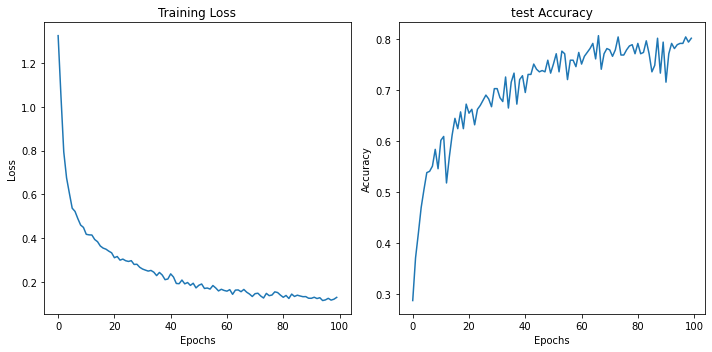

In [63]:
display_model_performance(loss_array_VGG16, acc_array_VGG16)

In [64]:
acc_VGG16 = test(model_VGG16, test_loader)

            
print("Test Accuracy: ", acc_VGG16)

Test Accuracy:  0.7969543147208121


In [65]:
# Evaluate the model and get labels and predictions
true_labels, pred_labels = test_with_predictions(model_Resnet18, test_loader)

# Compute confusion matrix
conf_matrix_VGG16 = confusion_matrix(true_labels, pred_labels)

# Compute classification report
class_report_VGG16 = classification_report(true_labels, pred_labels)

In [66]:
print("Confusion Matrix:")
print(conf_matrix_VGG16)

Confusion Matrix:
[[ 28  50  22   0]
 [  0 115   0   0]
 [  0   2 103   0]
 [  0  14   6  54]]


In [67]:
print("\nClassification Report:")
print(class_report_VGG16)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.44       100
           1       0.64      1.00      0.78       115
           2       0.79      0.98      0.87       105
           3       1.00      0.73      0.84        74

    accuracy                           0.76       394
   macro avg       0.86      0.75      0.73       394
weighted avg       0.84      0.76      0.73       394



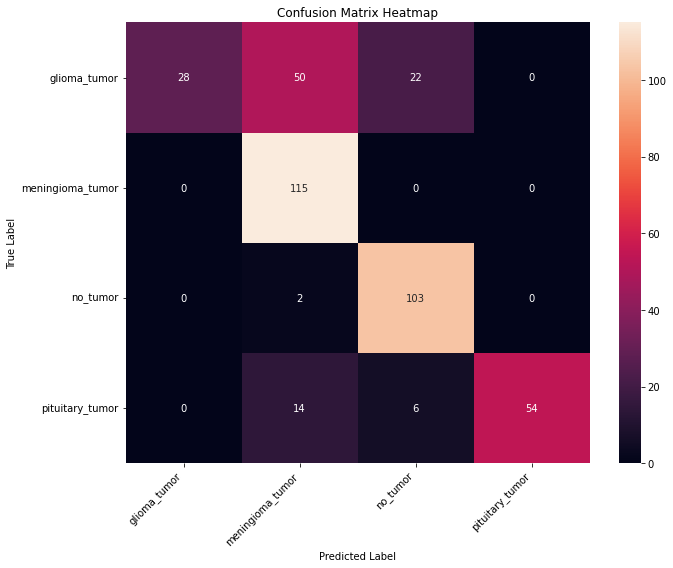

In [68]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
plt.title("Confusion Matrix Heatmap - VGG16")
sns.heatmap(conf_matrix_VGG16, annot=True, fmt="d", 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Model Name: GNN-VGG16


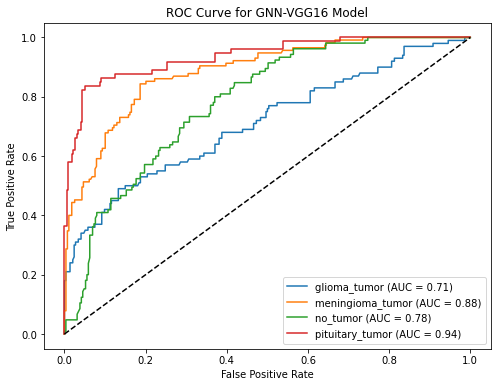

In [69]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
plot_roc_curve("GNN-VGG16", model_VGG16, test_loader, num_classes=4)


In [70]:

# Test accuracies obtained for each model
accuracies = [
    ("GraphCNN_VGG16", acc_VGG16),
    ("GraphCNN_Densenet121", acc_Densenet121),
    ("GraphCNN_Resnet18", acc_Resnet18),
]

# Print the accuracies in a visually appealing table (fancy_grid format)
table_str = tabulate(accuracies, headers=["Model", "Test Accuracy"], tablefmt="fancy_grid")

# Display the table
print(table_str)


╒══════════════════════╤═════════════════╕
│ Model                │   Test Accuracy │
╞══════════════════════╪═════════════════╡
│ GraphCNN_VGG16       │        0.796954 │
├──────────────────────┼─────────────────┤
│ GraphCNN_Densenet121 │        0.667513 │
├──────────────────────┼─────────────────┤
│ GraphCNN_Resnet18    │        0.756345 │
╘══════════════════════╧═════════════════╛


In [71]:
train_dataset.classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

****Predictions

In [19]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
import torch
from PIL import Image
import torchvision.transforms as transforms

# Add the dataset before running this cell (explained above) 
load_path = "/kaggle/input/data-set/models/model_VGG_complete.pth" 
model_VGG = torch.load(load_path)
model_VGG.eval() 

GraphCNN_VGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

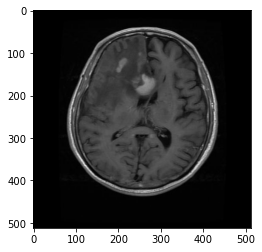

In [31]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/gg (3).jpg"
image = Image.open(image_path)

# Display the original image
plt.figure()
plt.imshow(image)  
plt.show()
from PIL import Image
import torchvision.transforms as transforms

#  Load the image
image = Image.open(image_path)

# Apply the same transformations used during training
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_tensor = data_transform(image)

In [32]:
image_tensor = image_tensor.unsqueeze(0)

# Ensure model is in evaluation mode and on the appropriate device
model_VGG.eval()
model_VGG.to(device) 

# Get the model's prediction (no gradients needed)
with torch.no_grad():
    output = model_VGG(image_tensor.type(dtype).to(device))
    predicted_class_index = int(torch.argmax(output)) 

# Access the corresponding class name
predicted_class_name = class_names[predicted_class_index] 

print("Predicted Class:", predicted_class_name)

Predicted Class: glioma_tumor


* Resnet - 18

In [72]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.type(torch.cuda.HalfTensor)  # Convert to half precision
    return image

In [73]:
def extract_features(model, image_path):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        features = model.forward_features(image_tensor)
    return features

In [74]:
image_path = "/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(100).jpg"

In [75]:
# Extract features using VGG16 model
vgg16_features = extract_features(model_VGG16, image_path)
VGG16_Features_Shape = vgg16_features.shape
print("VGG16 Features :", vgg16_features)

VGG16 Features : tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.2866e-03, 1.9492e+00, 2.1309e+00,  ..., 4.1055e+00,
           6.3047e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.3936e+00,  ..., 0.0000e+00,
           6.9482e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.6426e+00,  ..., 3.6597e-01,
           2.2107e-01, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.3457e+00, 3.2344e+00, 1.5186e

In [76]:
# Extract features using DenseNet121 model
densenet121_features = extract_features(model_Densenet121, image_path)
DenseNet121_Features_Shape = densenet121_features.shape
print("DenseNet121 Features :", densenet121_features)



DenseNet121 Features : tensor([[[[-1.0366e-03,  9.2125e-04,  1.9228e-04,  ..., -1.2589e-04,
            6.3801e-04, -3.8242e-04],
          [ 6.9427e-04,  4.2582e-04,  3.9577e-04,  ...,  4.1544e-05,
            2.2030e-04,  8.1635e-04],
          [-2.0683e-05, -9.3079e-04, -5.5981e-04,  ..., -2.4796e-04,
           -2.4533e-04, -5.2309e-04],
          ...,
          [-9.2983e-04, -6.8712e-04, -3.7599e-04,  ..., -6.8521e-04,
           -3.9196e-04, -9.1839e-04],
          [ 9.9540e-06, -5.4646e-04, -5.7697e-04,  ..., -3.9196e-04,
           -4.5609e-04, -6.5327e-04],
          [ 5.6362e-04, -2.3103e-04, -1.0233e-03,  ..., -1.1711e-03,
           -3.2973e-04, -3.9840e-04]],

         [[ 1.1566e-02,  3.0766e-03,  5.5265e-04,  ...,  4.2648e-03,
            7.5874e-03,  1.0300e-02],
          [ 1.6785e-02, -9.6283e-03, -3.6774e-03,  ...,  5.1613e-03,
           -2.1667e-03,  1.1955e-02],
          [ 4.5776e-03, -5.1956e-03,  1.6205e-02,  ...,  1.1879e-02,
            6.9084e-03,  2.0020e-02

In [77]:
# Extract features using ResNet18 model
resnet18_features = extract_features(model_Resnet18, image_path)
ResNet18_Features_Shape = resnet18_features.shape
print("ResNet18 Features :", resnet18_features)

ResNet18 Features : tensor([[[[0.0000, 1.2500, 1.9756,  ..., 1.5996, 0.4194, 0.4148],
          [0.7832, 3.8750, 5.3438,  ..., 3.3574, 1.3555, 1.3125],
          [0.7612, 4.3242, 6.2305,  ..., 5.6211, 4.1016, 3.1562],
          ...,
          [1.5693, 3.9023, 6.2852,  ..., 5.2891, 5.6211, 4.4570],
          [1.2354, 2.3105, 3.3008,  ..., 1.8525, 3.0176, 3.0137],
          [1.5576, 2.1230, 2.8301,  ..., 0.9336, 1.0000, 0.9487]],

         [[0.2510, 0.1014, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.1602, 2.8086, 4.0039,  ..., 0.0000, 0.0000, 0.0000],
          [2.4941, 6.4219, 8.6562,  ..., 2.1074, 0.5190, 0.1415],
          ...,
          [2.4766, 3.0742, 1.2617,  ..., 0.5479, 1.7031, 1.5586],
          [1.4434, 1.3359, 0.3572,  ..., 2.4043, 2.6582, 2.0820],
          [0.0000, 0.0000, 0.0000,  ..., 2.3789, 1.8525, 1.2051]],

         [[0.0000, 0.4075, 2.3359,  ..., 2.2324, 0.5986, 0.0000],
          [0.3506, 3.9355, 7.4922,  ..., 4.9336, 1.6982, 0.2181],
          [0.0000, 4.1

In [78]:

# Test accuracies obtained for each model
Features = [
    ("ResNet18 Features", ResNet18_Features_Shape),
    ("DenseNet121 Features", DenseNet121_Features_Shape),
    ("VGG16 Features", VGG16_Features_Shape),
]

# Print the accuracies in a visually appealing table (fancy_grid format)
table_Features = tabulate(Features, headers=["Model", "Test Accuracy"], tablefmt="fancy_grid")

# Display the table
print(table_Features)

╒══════════════════════╤═════════════════════════════╕
│ Model                │ Test Accuracy               │
╞══════════════════════╪═════════════════════════════╡
│ ResNet18 Features    │ torch.Size([1, 512, 7, 7])  │
├──────────────────────┼─────────────────────────────┤
│ DenseNet121 Features │ torch.Size([1, 1024, 7, 7]) │
├──────────────────────┼─────────────────────────────┤
│ VGG16 Features       │ torch.Size([1, 512, 7, 7])  │
╘══════════════════════╧═════════════════════════════╛


In [79]:
def preprocess_image_visualize(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(torch.float16).cuda()  # Convert to half precision and move to GPU
    return image

def extract_features_visualize(model, image_path):
    model.eval()
    with torch.no_grad():
        image_tensor = preprocess_image_visualize(image_path)
        features = model.forward_features(image_tensor)
    return features

In [80]:
def reduce_features(features, n_components=2):
    # Flatten the features to (n_samples, n_features)
    flattened_features = features.squeeze().cpu().numpy()
    flattened_features = flattened_features.reshape(flattened_features.shape[0], -1)
    
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(flattened_features)
    return reduced_features

In [81]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract features using VGG16 model
vgg16_features_visualize = extract_features_visualize(model_VGG16, image_path)
reduced_vgg16_features = reduce_features(vgg16_features_visualize)


In [82]:
# Extract features using DenseNet121 model
densenet121_features_visualize = extract_features_visualize(model_Densenet121, image_path)
reduced_densenet121_features = reduce_features(densenet121_features_visualize)

In [83]:
# Extract features using ResNet18 model
resnet18_features_visualize = extract_features_visualize(model_Resnet18, image_path)
reduced_resnet18_features = reduce_features(resnet18_features_visualize)

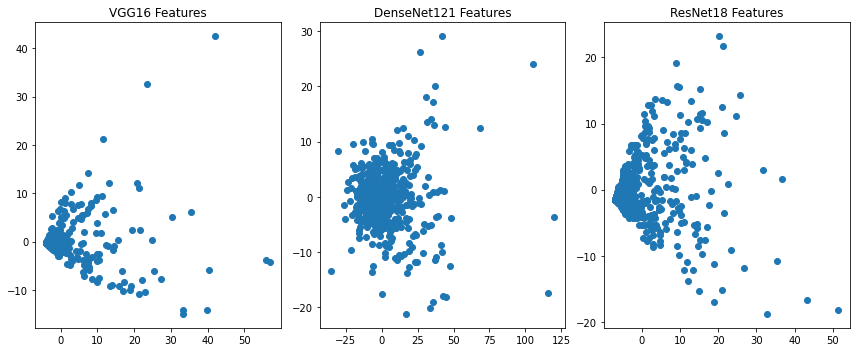

In [84]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(reduced_vgg16_features[:, 0], reduced_vgg16_features[:, 1])
plt.title('VGG16 Features')

plt.subplot(1, 3, 2)
plt.scatter(reduced_densenet121_features[:, 0], reduced_densenet121_features[:, 1])
plt.title('DenseNet121 Features')

plt.subplot(1, 3, 3)
plt.scatter(reduced_resnet18_features[:, 0], reduced_resnet18_features[:, 1])
plt.title('ResNet18 Features')

plt.tight_layout()
plt.show()

In [85]:
# import torch
# import torchvision.models as models
# import torchvision.transforms as transforms
# from PIL import Image
# import matplotlib.pyplot as plt

# # Load the ResNet-18 model
# resnet = models.resnet18(pretrained=True)
# resnet.eval()

# # Load and preprocess a sample image
# image_path = "/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/gg (1).jpg"
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# image = Image.open(image_path)
# input_tensor = preprocess(image)
# input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# # Extract features
# with torch.no_grad():
#     features = resnet.conv1(input_batch)  # Extract features from the first convolutional layer

# # Display extracted features
# plt.figure(figsize=(10, 10))
# for i in range(64):  # Assuming the first convolutional layer in ResNet-18 has 64 output channels
#     plt.subplot(8, 8, i + 1)
#     plt.imshow(features[0, i].cpu(), cmap='gray')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [86]:
# inputs = torch.randn(1, 3, 224, 224).to(device)  # (batch_size, channels, height, width)
# features = model.forward_features(inputs)


# # Print the shape of the extracted features
# print("Shape of extracted features:", features.shape)
# print("Extracted features:")
# print(features)